# SciPy (the Scientific Python Library)

Summary of what we have learned so far:

1) `numpy` supplies many common statistics and math functions for operating on arrays.
2) `netCDF4` and `pandas` allow you to read in multidimensional and labeled data.
3) `matplotlib` generates many standard plot types (line plots, scatter, images, contours, histograms)

 What about more complex operations such as filtering? How do people generate such _fancy_ statistics plots? 

[SciPy](https://scipy.org/) is an all-purpose scientific Python library that operates on NumPy arrays where you will find the following (and much more!):

1) [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html): convolution, filtering, peak finding, spectral analysis

2) [scipy.fft](https://docs.scipy.org/doc/scipy/reference/fft.html): fft, ifft, fftshift, sin and cos transforms

3) [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html): curve fitting, root finding, nonlinear least squares, minimization

4) [scipy.linalg](https://docs.scipy.org/doc/scipy/reference/linalg.html): matrix functions, decompositions, inv, eig

5) [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html): univariate and multivariate interpolation, cubic splines, smoothing and approximation

6) [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html): single/double/triple definite integrals, integrating over fixed samples, numerical methods (Runge-Kutta, Initial Value problems)

7) [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html): continuous distributions, discrete distributions, multivariate distributions, summary stats, frequency stats, correlation and association, resampling and Monte Carlo methods

You can consider SciPy tools to be roughly equivalent to tools you would find in Matlab or R. SciPy is also heavily tested, has millions of users, and regular maintainers.

## Data Analysis

Let's load the pier temperature data from our last workshop session. 

In [1]:
import numpy as np # numpy is usually imported as np (but doesn't have to be)
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

# import netcdf dataset
nc = Dataset('scripps_pier-2023.nc', mode='r')

# select salinity and time variables
temp = nc.variables['temperature'][:]
time = num2date(nc.variables['time'][:], nc.variables['time'].units, only_use_cftime_datetimes=False)


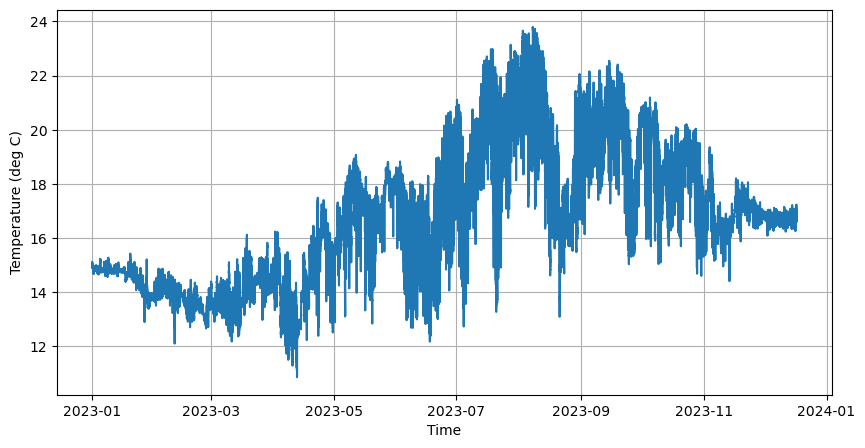

In [2]:
# Create Figure 
fig, axes = plt.subplots(figsize=(10,5))

# Plot the first 10 variables
axes.plot(time, temp)
axes.set_xlabel('Time')
axes.set_ylabel('Temperature (deg C)')
axes.grid(True)

# Display figure
plt.show()

### Detrend and Filter with scipy.signal

First, let's turn our timeseries of temperature, into a timeseries of temperature anomaly.

In [3]:
from scipy import signal 

# detrend our data 
temp_anomaly = signal.detrend(temp)
print(np.mean(temp_anomaly))  # should be close to zero

0.00014015801


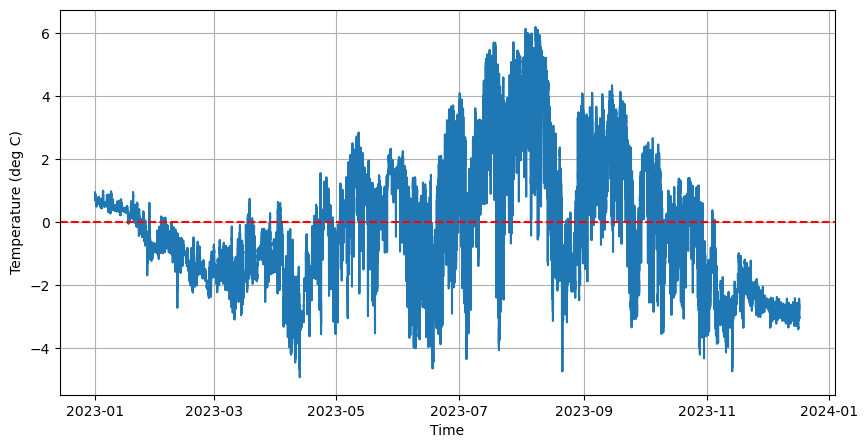

In [4]:
fig, axes = plt.subplots(figsize=(10,5))
# Plot the first 10 variables
axes.plot(time, temp_anomaly)
axes.axhline(np.mean(temp_anomaly),linestyle='--', color='red', label='Mean')
axes.set_xlabel('Time')
axes.set_ylabel('Temperature (deg C)')
axes.grid(True)

# Display figure
plt.show()


That data is pretty noisy! We can filter it to remove signals that are shorter period than 1 day. Looking at the figure below, our data appears to be taken every 5 minutes.

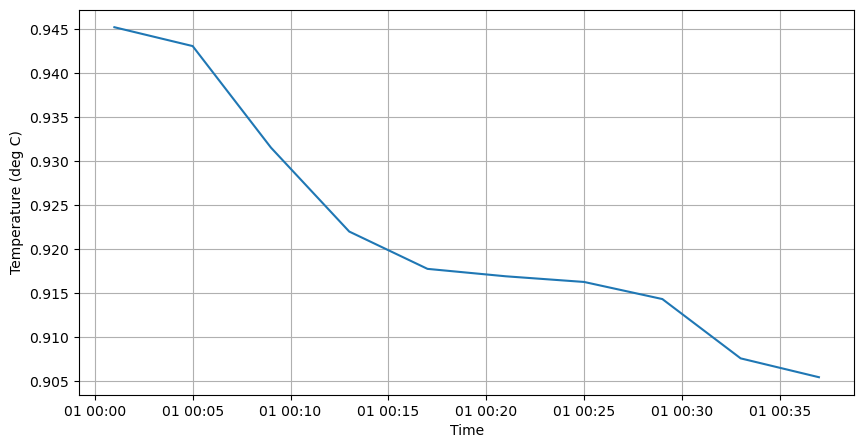

In [5]:
# Create Figure 
fig, axes = plt.subplots(figsize=(10,5))

# Plot the first 10 variables
axes.plot(time[:10], temp_anomaly[:10])
axes.set_xlabel('Time')
axes.set_ylabel('Temperature (deg C)')
axes.grid(True)

# Display figure
plt.show()

In [6]:
dt_minutes = 5 # timestep in minutes
fs = 1440 / dt_minutes  # sampling frequency, minutes/day / minutes/sample = samples/day
nyquist = fs / 2 

# Cutoff
cutoff_cpd = 1.0  # cycles per day
Wn = cutoff_cpd / nyquist

# Design filter
order = 4
sos = signal.butter(order, Wn, btype='low', output='sos')

# Apply filtering
filtered = signal.sosfiltfilt(sos, temp_anomaly)

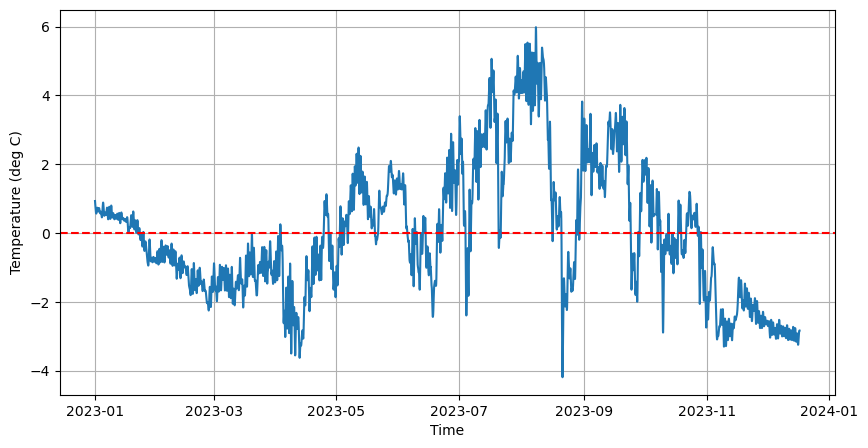

In [7]:
# Create Figure 
fig, axes = plt.subplots(figsize=(10,5))

axes.plot(time, filtered)
axes.axhline(np.mean(filtered),linestyle='--', color='red', label='Mean')
axes.set_xlabel('Time')
axes.set_ylabel('Temperature (deg C)')
axes.grid(True)

# Display figure
plt.show()

### Fitting a Distribution with scipy.stats

Perhaps we want a way to summarize our temperature anomaly data. One way to do this is to fit a distribution to it. Naively we can start with a normal distribution.

4.5219205500316825e-05 1.9543337126378342


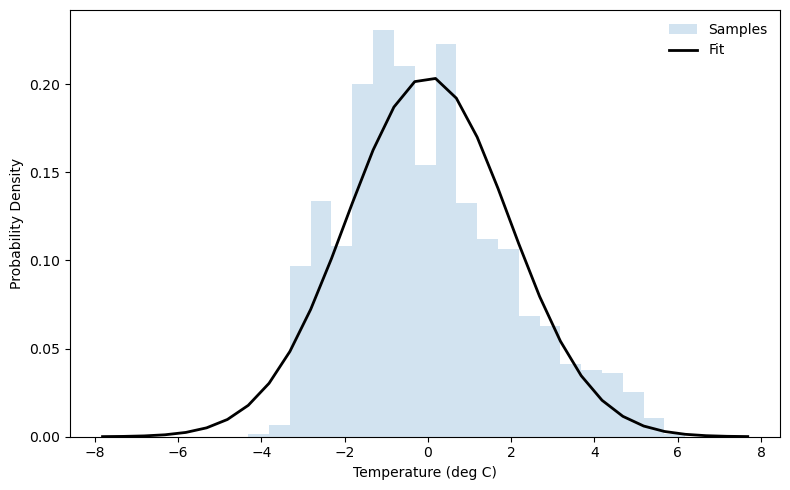

In [8]:
from scipy import stats

mu, sigma = stats.norm.fit(filtered, method="MLE")  # do a maximum-likelihood fit of a normal distribution
print(mu, sigma) # print out the mean and standard deviation

# Plot figure
bins = np.arange(mu - 4 * sigma, mu + 4 * sigma, 0.5) # create bins for histogram using the mean and + or - 4 standard deviations

fig, axes = plt.subplots(figsize=(8,5))
axes.hist(filtered, density=True, histtype='stepfilled',
         alpha=0.2, label='Samples',bins=bins)
axes.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma),
         'k-', lw=2, label='Fit')
axes.set_xlabel('Temperature (deg C)')
axes.set_ylabel('Probability Density')
axes.legend(loc='best', frameon=False)
plt.tight_layout()

In [9]:
# how good is a normal distribution? lets use kurtosis and skew 
kurt = stats.kurtosis(filtered)
skw = stats.skew(filtered)
print(f'Kurtosis: {kurt}, Skew: {skw}')

Kurtosis: -0.17225053286842096, Skew: 0.5672473389299741


This distribution appears to be skewed toward positive temperature anomalies. Since the distribution looks roughly normal, but with a slight skew, we can try a skew-normal distribution.

Shape (a)  = 3.805
Location   = -2.427
Scale      = 3.116


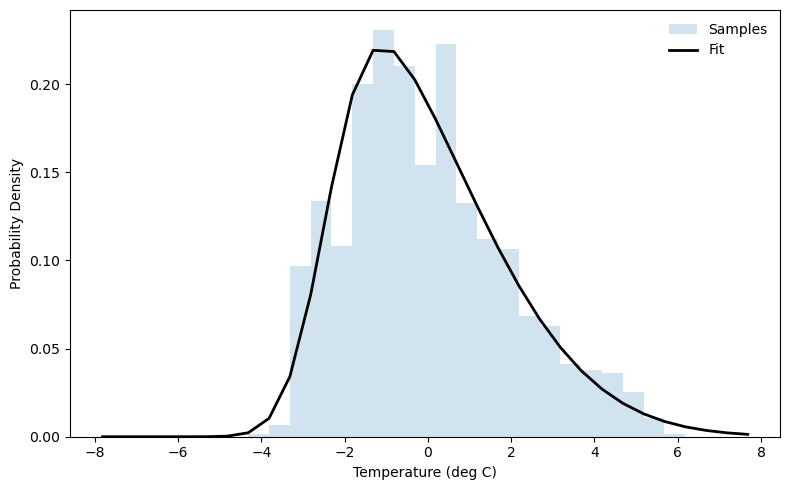

In [10]:
# Fit skew-normal: returns shape, loc, scale
a_hat, loc_hat, scale_hat = stats.skewnorm.fit(filtered)

print(f"Shape (a)  = {a_hat:.3f}")
print(f"Location   = {loc_hat:.3f}")
print(f"Scale      = {scale_hat:.3f}")

# Compare fit to histogram
fig, axes = plt.subplots(figsize=(8,5))
axes.hist(filtered, density=True, histtype='stepfilled',
         alpha=0.2, label='Samples',bins=bins)
axes.plot(bins, stats.skewnorm.pdf(bins, a_hat, loc_hat, scale_hat),
         'k-', lw=2, label='Fit')
axes.set_xlabel('Temperature (deg C)')
axes.set_ylabel('Probability Density')
axes.legend(loc='best', frameon=False)
plt.tight_layout()

### Solving an Initial Value Problem with scipy.integrate

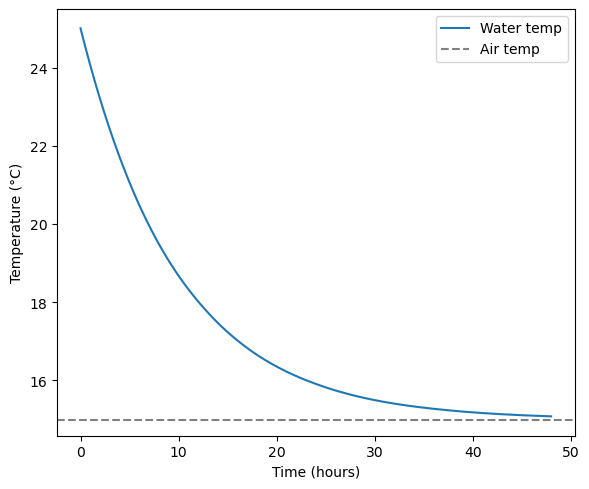

In [15]:
from scipy import integrate

# Parameters
T_air = 15.0      # °C
k = 0.1           # hr^-1 cooling rate
T0 = 25.0         # initial ocean mixed layer temperature (°C)
t_span = (0, 48)  # hours
t_eval = np.linspace(*t_span, 200)

# ODE system
def cooling(t, T):
    return -k * (T - T_air)

# Solve
sol = integrate.solve_ivp(cooling, t_span, [T0], t_eval=t_eval)

# Plot
fig, axes = plt.subplots(figsize=(6, 5))
axes.plot(sol.t, sol.y[0], label="Water temp")
axes.axhline(T_air, color="gray", linestyle="--", label="Air temp")
axes.set_xlabel("Time (hours)")
axes.set_ylabel("Temperature (°C)")
axes.legend()
plt.tight_layout()